---
title: Correlations with different DAGs
mathjax: True
toc: true
toc_sticky: true
categories: [data science, statistics]
---

One of the lessons from [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) that really hit home for me was the importance of considering the data generation process. Different datasets can show similar patterns, but the data generation can be different. I'll illustrate this below, showing how correlated data can arise from these varying processes.

As an homage to someone who's recently been in the news ... [LFG!](https://media.giphy.com/media/26FL5WoWnkl0xvXnG/giphy.gif)

In [16]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from statsmodels import api as sm

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

We'll have three different directed acyclic graphs (DAGs) showing relationships with only three variables, [named](https://media.giphy.com/media/3oEduXdm2gjnrsJBOo/giphy.gif) X, Y, and Z. In all of them, we'll have 100 datapoints. In all of them, `X` will be our "predictor" variable and `Y` will always be the "outcome" variable. `Z` will be the wild card, moving around so we will see what effects it has on the relationship between `X` and `Y`.

The first will be a mediator, AKA a pipe. Here `Z` passes on information from `X` to `Y`.

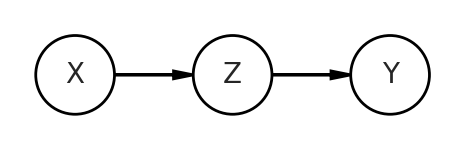

<IPython.core.display.Javascript object>

In [7]:
dag = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"),
        ("Z", "Y"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "X": (0, 0),
    "Z": (1, 0),
    "Y": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render();

When I say "data generation", I literally mean that. We can simulate the relationships between all variables. Since X is a starting point, that is the easiest to get. We'll simply take 100 random samples from a normal distribution with mean 0, standard deviation of 1 (represented in `stats.norm.rvs` as `loc` and `scale`, respectively). Then to generate Z, we'll take another random samples, where the mean of this new normal distribution is the product of a coefficient `bXZ` and `X`.  We're drawing Z from a normal distribution, because a simple multiplication would give perfectly correlated data. That's not what we're trying to represent. We then do something similar with Y, expect this time it is the product of `bZY` and `Z`.

A few quick notes you may be wondering about: my assignment of value to the coefficients is arbitrary and I'm appending "p" to the variable names, like `Xp`, to represent the X variable in this pipe dag.

In [4]:
n = 100

# pipe   X > Z > Y
bXZ = 1
bZY = 1

Xp = stats.norm.rvs(loc=0, scale=1, size=n)
Zp = stats.norm.rvs(loc=bXZ*Xp, scale=1, size=n)
Yp = stats.norm.rvs(loc=bZY*Zp, scale=1, size=n)


<IPython.core.display.Javascript object>

We'll plot the relationship of `X` and `Y` from this pipe at the end, after we generate all data examples. Let's look at the second DAG, which is a fork. `Z` influences both `X` and `Y`.

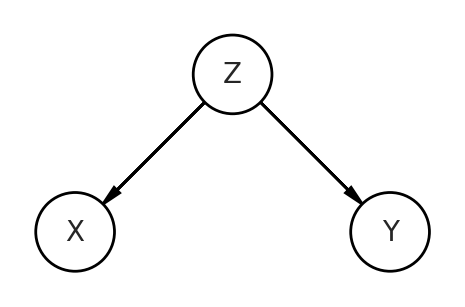

<IPython.core.display.Javascript object>

In [8]:
dag = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("Z", "X"),
        ("Z", "Y"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "X": (0, 0),
    "Z": (1, 1),
    "Y": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render();

The code will look similar as the pipe, but the relationships of the data generation process will reflect the DAG depicting this fork. You can see how `Z` is influencing both the predictor `X` and the outcome `Y`. `Z` is a confound of this relationship.

In [9]:
# fork   X < Z > Y
bZX = 1
bZY = 1

Zf = stats.norm.rvs(size=n)
Xf = stats.norm.rvs(bZX*Zf, size=n)
Yf = stats.norm.rvs(bZY*Zf, size=n)

<IPython.core.display.Javascript object>

Now let's move onto the trickiest DAG, which is the collider. Here, our predictor and outcome variables are no longer the consequences of `Z`, but are now the *causes* of `Z`. They both influence and "collide" on Z.

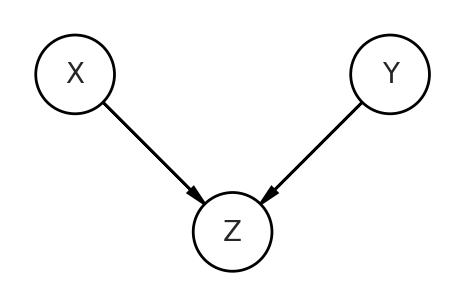

<IPython.core.display.Javascript object>

In [10]:
dag = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"),
        ("Y", "Z"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "X": (0, 1),
    "Z": (1, 0),
    "Y": (2, 1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render();

To get correlated data with the collider, we'll have to do some non-intuitive things that are still represented on this DAG. I'll show the code then explain after.

In [11]:
# collider   X > Z < Y
from scipy.special import expit

n=200

bXZ = 2
bYZ = 2

Xc = stats.norm.rvs(loc=0, scale=1.5, size=n)
Yc = stats.norm.rvs(loc=0, scale=1.5, size=n)
Zc = stats.bernoulli.rvs(expit(bXZ*Xc - bYZ*Yc), size=n)

df_c = pd.DataFrame({"Xc":Xc, "Yc":Yc, "Zc":Zc, "Znorm":bXZ*Xc - bYZ*Yc})
df_c0 = df_c[df_c['Zc']==0]
df_c1 = df_c[df_c['Zc']==1]

<IPython.core.display.Javascript object>

What are we doing in the code?

1. We're going to make `Z` take on a value of 0 or 1. It is essentially a categorical variable. This is to aid in visualization.
2. To ensure `Z` acts as a collider, we still have to represent the causal influences of `X` and `Y`. Z is represented by first taking the difference `bXZ*Xc - bYZ*Yc` and applying an expit (AKA logistic sigmoid function). We take the difference to get a positive correlated relationship to mimic the pipe and fork examples, but it still is a faithful representation of the DAG.
3. We're going to show only one subset of data, those with `Z` again to aid in visualization.
4. Since we're subsetting the data, we double the number of observations.

In [12]:
df_c.head()

,Xc,Yc,Zc,Znorm
0,-0.699453,1.185703,0,-3.770312
1,-2.572501,1.878710,0,-8.902422
2,1.529135,0.312649,1,2.432973
3,1.583378,2.532354,0,-1.897951
4,0.018115,-0.829417,1,1.695062


<IPython.core.display.Javascript object>

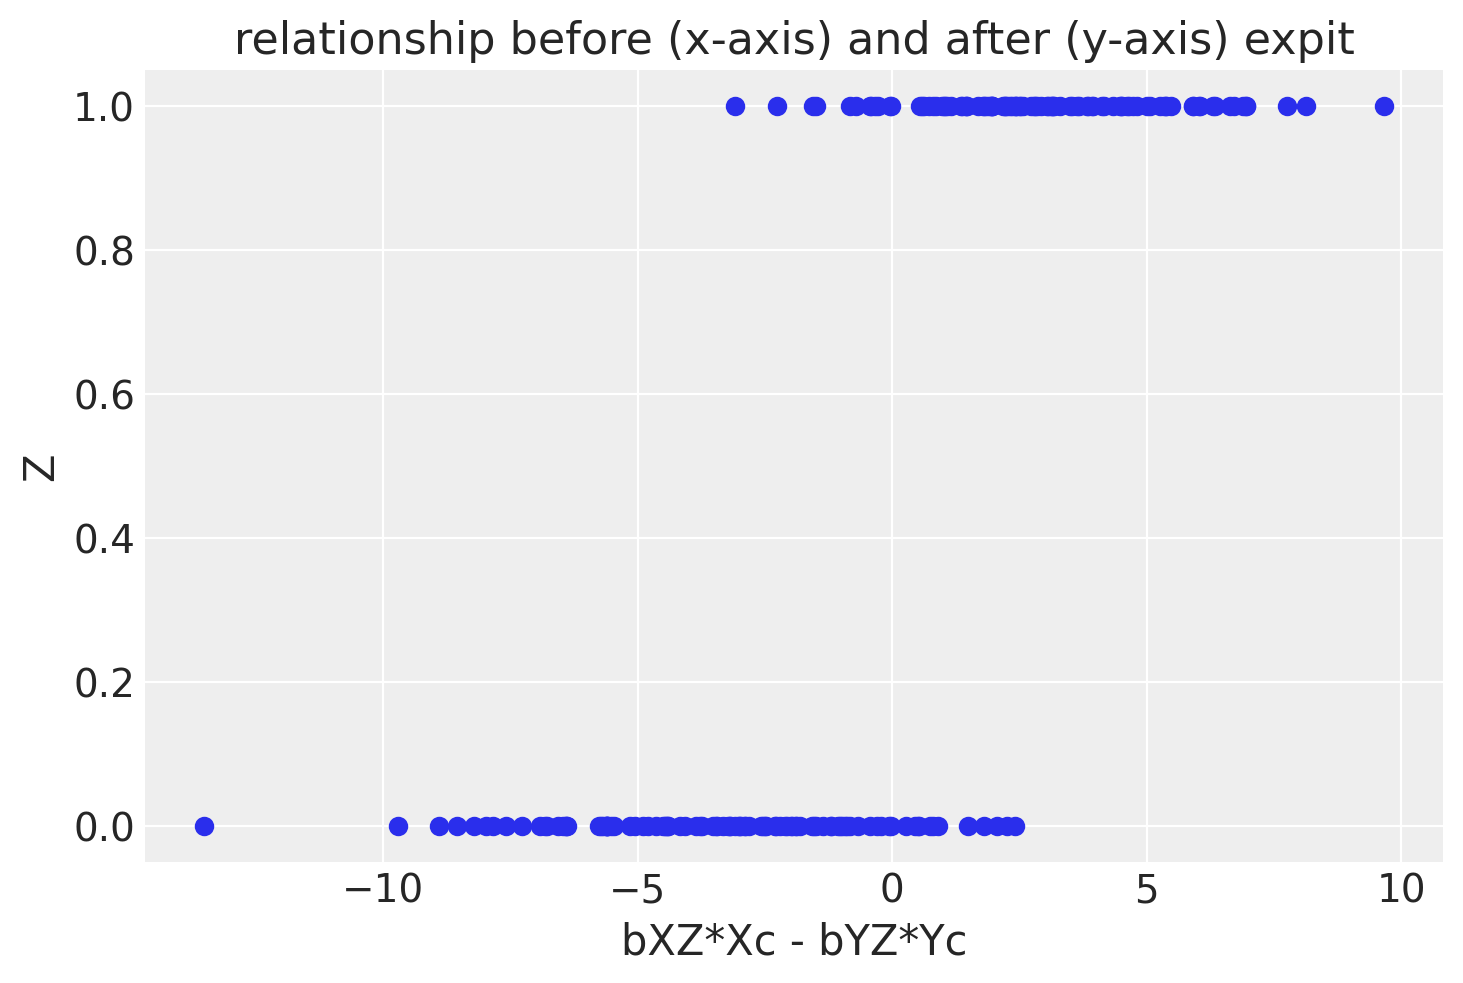

<IPython.core.display.Javascript object>

In [13]:
f, ax1 = plt.subplots()
ax1.scatter(df_c['Znorm'], df_c['Zc'])
ax1.set(xlabel='bXZ*Xc - bYZ*Yc', ylabel='Z', title='relationship before (x-axis) and after (y-axis) expit');


OK, now let's plot the data!

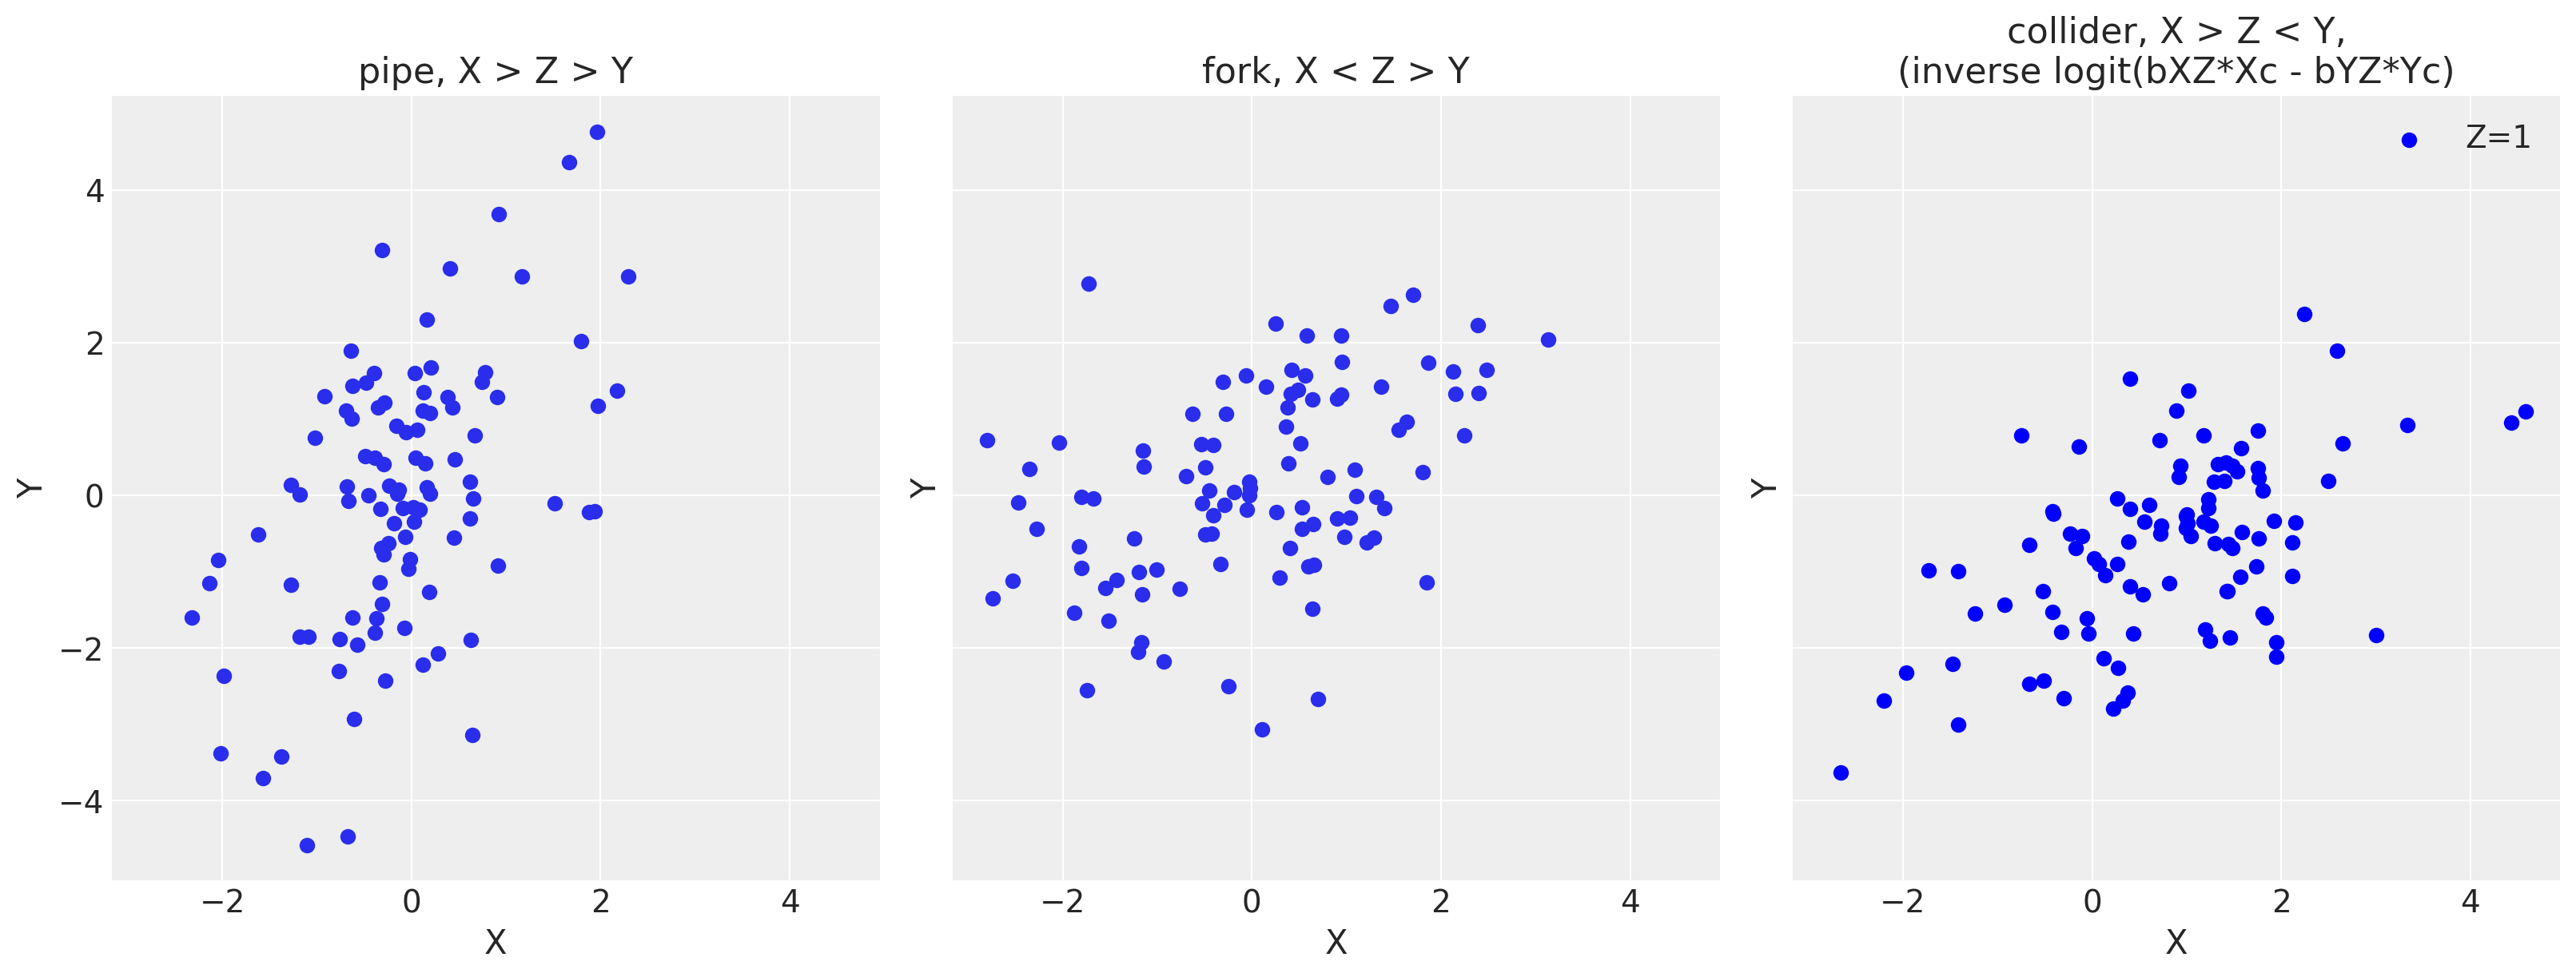

<IPython.core.display.Javascript object>

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)
ax1.scatter(Xp, Yp)
ax1.set(xlabel='X', ylabel='Y', title='pipe, X > Z > Y')

ax2.scatter(Xf, Yf)
ax2.set(xlabel='X', ylabel='Y', title='fork, X < Z > Y')

#ax3.scatter(df_c0['Xc'], df_c0['Yc'], color='gray', label='Z=0')
ax3.scatter(df_c1['Xc'], df_c1['Yc'], color='blue', label='Z=1')
ax3.set(xlabel='X', ylabel='Y', title='collider, X > Z < Y,\n(inverse logit(bXZ*Xc - bYZ*Yc)')
ax3.legend();

In [94]:
betaX_PwZ_int = sm.OLS(Yp, np.concatenate([Xp.reshape(100, 1), Zp.reshape(100, 1)], axis=1)).fit().conf_int(alpha=0.05)[0].tolist()
betaX_PnoZ_int = sm.OLS(Yp, Xp).fit().conf_int(alpha=0.05)[0].tolist()

print("Pipe coefficients")
print("coefficient of X on Y, including Z in the model: {0:0.3f} to {1:0.3f}".format(betaX_PwZ_int[0], betaX_PwZ_int[1]))
print("coefficient of X on Y, excluding Z in the model: {0:0.3f} to {1:0.3f}".format(betaX_PnoZ_int[0], betaX_PnoZ_int[1]))

Pipe coefficients
coefficient of X on Y, including Z in the model: -0.270 to 0.301
coefficient of X on Y, excluding Z in the model: 0.645 to 1.284


<IPython.core.display.Javascript object>

In [92]:
betaX_FwZ_int = sm.OLS(Yf, np.concatenate([Xf.reshape(100, 1), Zf.reshape(100, 1)], axis=1)).fit().conf_int(alpha=0.05)[0].tolist()
betaX_FnoZ_int = sm.OLS(Yf, Xf).fit().conf_int(alpha=0.05)[0].tolist()

print("Fork coefficients")
print("coefficient of X on Y, including Z in the model: {0:0.3f} to {1:0.3f}".format(betaX_FwZ_int[0], betaX_FwZ_int[1]))
print("coefficient of X on Y, excluding Z in the model: {0:0.3f} to {1:0.3f}".format(betaX_FnoZ_int[0], betaX_FnoZ_int[1]))

Fork coefficients
coefficient of X on Y, including Z in the model: -0.384 to 0.037
coefficient of X on Y, excluding Z in the model: 0.244 to 0.592


<IPython.core.display.Javascript object>

In [93]:
betaX_CwZ_int = sm.OLS(df_c1['Yc'], df_c1[['Xc', 'Zc']]).fit().conf_int(alpha=0.05).iloc[0, :].tolist()
betaX_CnoZ_int = sm.OLS(df_c1['Yc'], df_c1['Xc']).fit().conf_int(alpha=0.05).iloc[0, :].tolist()

print("Collider coefficients")
print("coefficient of X on Y, including Z in the model: {0:0.3f} to {1:0.3f}".format(betaX_CwZ_int[0], betaX_CwZ_int[1]))
print("coefficient of X on Y, excluding Z in the model: {0:0.3f} to {1:0.3f}".format(betaX_CnoZ_int[0], betaX_CnoZ_int[1]))

Collider coefficients
coefficient of X on Y, including Z in the model: 0.323 to 0.638
coefficient of X on Y, excluding Z in the model: -0.078 to 0.282


<IPython.core.display.Javascript object>

As you can see, there's a positive correlated relationship despite the DAGs being different and working with only three variables! This drives home the point that we can't look only at our data to infer the proper relationships. A data generating model is key to know how to stratify our models.

Appendix: Environment and system parameters

In [95]:
%watermark -n -u -v -iv -w

Last updated: Thu Mar 17 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib : 3.3.4
pandas     : 1.2.1
arviz      : 0.11.1
numpy      : 1.20.1
daft       : 0.1.0
seaborn    : 0.11.1
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
statsmodels: 0.12.2
scipy      : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>